# Imports

In [6]:
import collections
import itertools
import os
import random
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchmetrics
from albumentations.augmentations import transforms as AT
from albumentations.augmentations.dropout.coarse_dropout import CoarseDropout
from albumentations.pytorch import ToTensorV2
from madgrad import MADGRAD
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm

cv2.setNumThreads(4)
cv2.ocl.setUseOpenCL(True)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(33)

# Classes 

In [2]:
class CharEncoder:
    """Encode and decode chars
    
    Args:
        alphabet (str): string of all chars
    """
    def __init__(self, alphabet: str):
        alphabet = alphabet.lower()
        self._alphabet = alphabet

        self._encode_dict = {}
        for i, char in enumerate(alphabet):
            self._encode_dict[char] = i + 1

        self._decode_dict = {v: k for k, v in self._encode_dict.items()}
        self._decode_dict[0] = ""
        
    def encode(self, text: Iterable[str]) -> torch.Tensor:
        """Encode chars

        Args:
            text (Iterable[str]): set of strings to encode 

        Returns:
            torch.Tensor: flat Tensor with encoded chars
        """
        text = "".join(text).lower()
        text = list(map(self._encode_dict.get, text))
        return torch.IntTensor(text)

    def decode(self, x: torch.Tensor, length: int) -> np.ndarray:
        """Decode numbers 

        Args:
            x (torch.Tensor): flat Tensor with encoded chars
            length (int): length of one word

        Returns:
            np.ndarray: ndarray with decoded numbers
        """
        x = np.array(list(map(lambda x: self._decode_dict.get(x.item()), x)))
        x = np.split(x, len(x) // length)
        x = np.apply_along_axis(
            lambda k: "".join(c[0] for c in itertools.groupby(k)), 1, x
        )
        return np.array(x)

    @property
    def alphabet(self):
        return self._alphabet
    

In [5]:
class MyDataset(data.Dataset):
    """Dataset for CCPD2019
    
    Args:
        files (Iterable[Path]): paths to all images
        transform (A.Compose): transforms from albumentations
        alphabet (bool, optional): Create an alphabet from filenames or not. Defaults to True.
    """
    def __init__(
        self, files: Iterable[Path], transform: A.Compose, alphabet: bool = True
    ) -> None:
        super().__init__()
        self._files = files
        self._labels = []
        self._alphabet = alphabet
        self.transform = transform
        if alphabet is True:
            self._alphabet = set()
        for file in files:
            label = file.stem.split("-")[1].lower()
            self._labels.append(label)

            if alphabet is True:
                self._alphabet |= set(label)

    @property
    def alphabet(self) -> str:
        if not self._alphabet:
            raise AttributeError()
        return self._alphabet

    def load_sample(self, filepath: Path) -> np.ndarray:
        """Load image via cv2

        Args:
            filepath (Path): path to image
        Returns:
            np.ndarray: loaded image
        """
        image = cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def __len__(self) -> int:
        return len(self._files)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        x = self.load_sample(self._files[index])
        x = self.transform(image=x)["image"] / 256
        y = self._labels[index]
        return x, y


In [6]:
class Accuracy:
    """Accuracy metric
    """
    def __call__(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """Calculate accuracy

        Args:
            y_pred (np.ndarray): predicted labels
            y_true (np.ndarray): true labels
            
        Returns:
            float: accuracy
        """
        if y_pred.shape != y_true.shape:
            raise AttributeError
        return np.sum(y_true==y_pred)/len(y_true)

In [7]:
class BiLSTM(nn.Module):
    """Bidirectional LSTM
    
    Args:
        n_channels (int): number of expected features in the input x
        n_hidden (int): number of features in the hidden state h
        n_out (int): number of out features
    """
    def __init__(self, n_channels: int, n_hidden: int, n_out: int):

        super(BiLSTM, self).__init__()
        self.rnn = nn.LSTM(n_channels, n_hidden, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(n_hidden * 2, n_out)

    def forward(self, input: torch.Tensor):
        recurrent, _ = self.rnn(input)
        output = self.linear(recurrent)
        return output

class FCNN(nn.Module):
    """Fully-convolutional CNN
    
    Args:
        n_out (int): number of out features
    """
    def __init__(self, n_out: int):
        super(FCNN, self).__init__()
        #in 3x32x128
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        #out 64x16x128
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        #out 128x8x64
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        #out 256x4x64
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        #out 512x2x32
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        #out 512x1x32
        
        self.fc = nn.Sequential(
            nn.Flatten(2),
            nn.Linear(32, 256),
            nn.ReLU(True),
            nn.Linear(256, n_out)
        )
    def forward(self, input: torch.Tensor):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc(x)
        return x
    
class Model(nn.Module):
    """Model for car license plate recognition
    
    Args:
        alphabet_length (_type_): length of alphabet
        sequence_length (int, optional): FCNN output width. Defaults to 16.
        lstm_layers (int, optional): number of LSTM hidden layers. Defaults to 256.
    """
    def __init__(self, alphabet_length, sequence_length=16, lstm_layers=256):
        super(Model, self).__init__()
        
        self.alphabet_length = alphabet_length
        self.sequence_length = sequence_length
        self.cnn = FCNN(sequence_length)
        self.rnn = nn.Sequential(
            BiLSTM(512, lstm_layers, lstm_layers),
            BiLSTM(lstm_layers, lstm_layers, alphabet_length))
        
    def forward(self, x):
        x = self.cnn(x).permute(0, 2, 1) # b, w, c
        output = self.rnn(x)
        return output
    
    

In [8]:
class OCR:
    """OCR Model trainer

    Args:
        model (nn.Module): model to train
        optimizer (torch.optim.Optimizer): optimizer
        criterion (nn.CTCLoss): criterion
        target_length (int): length of target
        alphabet (str): string of all possible target characters
        gpu_transform (Optional[transforms.Compose], optional):
            transforms that produced by the GPU. Defaults to None.
        scheduler (Optional[torch.optim.lr_scheduler._LRScheduler], optional):
            scheduler. Defaults to None.
        device (str, optional): device. Defaults to "cuda".
    """

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        criterion: nn.CTCLoss,
        target_length: int,
        alphabet: str,
        gpu_transform: Optional[transforms.Compose] = None,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
        device="cuda",
    ) -> None:
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.target_length = target_length
        self.alphabet = alphabet
        self.gpu_transform = gpu_transform
        self.scheduler = scheduler
        self.device = device
        self.label_encoder = CharEncoder(alphabet)

        self._best_score = -1
        self._best_weights = None

        if len(alphabet) + 1 != model.alphabet_length:
            raise ValueError(
                "The size of the model target does not match the specified one"
            )

    def _count_phase_metrics(self, phase_metrics: Dict, batch_metrics: Dict):
        """Add batcg metrics to phase metrics

        Args:
            phase_metrics (Dict): dict of phase metrics
            batch_metrics (Dict): dict of batch metrics
        """
        for metric in batch_metrics:
            phase_metrics[metric] += batch_metrics[metric]

    def _batch_handler(
        self,
        x_batch: torch.Tensor,
        y_batch: torch.Tensor,
        y_decoded: np.ndarray,
        metrics: Iterable,
    ) -> Tuple[torch.Tensor, Dict]:
        """Handle batch

        Args:
            x_batch (torch.Tensor): images batch
            y_batch (torch.Tensor): encoded targets batch
            y_decoded (np.ndarray): decoded targets batch
            metrics (Iterable): metrics to calculate

        Returns:
            Tuple[torch.Tensor, Dict]: loss and dict of metrics
        """
        outputs, preds = self.predict(x_batch)
        loss = self.criterion(
            outputs.permute(1, 0, 2).log_softmax(-1),  # l, b, c
            y_batch,
            torch.IntTensor([self.model.sequence_length] * len(y_batch)),
            torch.IntTensor([self.target_length] * len(y_batch)),
        )
        counted_metrics = {
            metric.__class__.__name__: metric(preds, y_decoded) * len(y_batch)
            for metric in metrics
        }
        return loss, counted_metrics

    def _phase_handler(
        self,
        phase: str,
        dataloader: data.DataLoader,
        metrics: Iterable,
        load_best_weights: Optional[str] = None,
    ) -> Tuple[float, Dict]:
        """Handle phase

        Args:
            phase (str): phase name
            dataloader (data.DataLoader): dataloader
            metrics (Iterable): metrics to calculate
            load_best_weights (Optional[str], optional):
                by which metric best weights of model will be loaded at the end of training.
                If None, weights will not be loaded. Defaults to None.

        Returns:
            Tuple[float, Dict]: loss and dict of metrics
        """
        phase_loss = 0
        phase_metrics = collections.defaultdict(lambda: 0)
        for x_batch, y_batch in tqdm(dataloader, desc=f"Phase {phase}"):
            x_batch = x_batch.to(self.device)

            y_decoded = np.array(y_batch)
            y_batch = self.label_encoder.encode(y_batch)
            y_batch = y_batch.to(self.device).view(-1, self.target_length)

            if phase == "train":
                if self.gpu_transform is not None:
                    x_batch = self.gpu_transform(x_batch)
                self.optimizer.zero_grad()

            bacth_loss, batch_metrics = self._batch_handler(
                x_batch, y_batch, y_decoded, metrics
            )

            if phase == "train":
                bacth_loss.backward()
                self.optimizer.step()

            phase_loss += bacth_loss.item() * len(y_batch)
            self._count_phase_metrics(phase_metrics, batch_metrics)

        phase_loss /= len(dataloader.dataset)
        phase_metrics = {
            metric: value / len(dataloader.dataset)
            for metric, value in phase_metrics.items()
        }

        if (
            phase == "val"
            and load_best_weights
            and phase_metrics[load_best_weights] > self._best_score
        ):
            self._best_score = phase_metrics[load_best_weights]
            self._best_weights = self.model.state_dict()

        tqdm.write(f"\tLoss: {phase_loss:0.5f}")
        for metric, value in phase_metrics.items():
            tqdm.write(f"\t{metric}: {value:0.5f}")
        print()
        return phase_loss, dict(phase_metrics)

    def fit(
        self,
        train: data.DataLoader,
        val: data.DataLoader,
        num_epochs: int,
        metrics: Iterable,
        load_best_weights: Optional[str] = "Accuracy",
        scheduler_metric: Optional[str] = None,
    ) -> Tuple[List, List]:
        """fit model

        Args:
            train (data.DataLoader): train dataloader
            val (data.DataLoader): val dataloader
            num_epochs (int): number of epochs
            metrics (Iterable): metrics to calculate
            load_best_weights (Optional[str], optional): by which metric 
                best weights of the model will be loaded at the end of training.
                If None, weights will not be loaded. Defaults to "Accuracy"
            scheduler_metric (Optional[str], optional):
                needed if scheduler requires metric for step. Defaults to None.

        Returns:
            Tuple[List, List]: train losses and val losses
        """
        if scheduler_metric is not None and self.scheduler is None:
            raise ValueError("Scheduler is not specified")
        if load_best_weights not in metrics:
            raise ValueError("{load_best_weights} is not specified in metrics")

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            tqdm.write(f"Epoch {epoch+1:03d}")

            self.model.train()
            train_loss, train_metrics = self._phase_handler("train", train, metrics)

            self.model.eval()
            with torch.no_grad():
                val_loss, val_metrics = self._phase_handler(
                    "val", val, metrics, load_best_weights
                )

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            if self.scheduler:
                tqdm.write(f"\nLR: {self.optimizer.param_groups[0]['lr']}")
                if scheduler_metric:
                    self.scheduler.step(val_metrics[scheduler_metric])
                else:
                    self.scheduler.step()

            tqdm.write("-" * 40)

        if load_best_weights:
            self.model.load_state_dict(self._best_weights)
        self._best_weights = None

        return train_losses, val_losses

    @torch.no_grad()
    def score_test(
        self, dataloader: data.DataLoader, metrics: Iterable
    ) -> Tuple[float, Dict]:
        """Calculate metrics on test data

        Args:
            dataloader (data.DataLoader): test dataloader
            metrics (Iterable): metrics to calculate

        Returns:
            Tuple[float, Dict]: loss and dict of metrics
        """
        self.model.eval()
        test_loss, test_metrics = self._phase_handler("test", dataloader, metrics)
        return test_loss, test_metrics

    @torch.no_grad()
    def get_test_scores(
        self, dataset: data.Dataset, metric: torchmetrics.Metric, device: str = "cpu"
    ) -> List:
        """Get score for each image in test

        Args:
            dataset (data.Dataset): test dataset
            metric (torchmetrics.Metric): metric to calculate
            device (str, optional): device. Defaults to "cpu".

        Returns:
            List: list of scores
        """
        self.model.to(device)
        self.model.eval()

        metric_list = []
        for x, y in tqdm(dataset):
            x = x.to(device)
            outputs, preds = self.predict(x)
            metric_list.append(
                metric(
                    preds,
                    [
                        y,
                    ],
                ).item()
            )

        self.model.to(self.device)
        return metric_list

    def predict(self, x: torch.Tensor) -> Tuple[torch.Tensor, np.ndarray]:
        """predict

        Args:
            x (torch.Tensor): one or more images

        Returns:
            Tuple[torch.Tensor, np.ndarray]: raw output, decoded output
        """
        if x.dim() == 3:
            x = x.unsqueeze(0)
        outputs = self.model(x)
        preds = self.label_encoder.decode(
            torch.argmax(outputs, 2).flatten(), self.model.sequence_length
        )
        return outputs, preds

    def state_dict(self) -> Dict:
        """Get state dict of:
        model, optimizer, scheduler, target_length and alphabet

        Returns:
            Dict: state dict
        """
        state_dict = {
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "scheduler": self.scheduler.state_dict(),
            "target_length": self.target_length,
            "alphabet": self.alphabet,
        }
        return state_dict

    def load_state_dict(
        self, state_dict: Dict, load_optimizer: bool = True, load_scheduler: bool = True
    ) -> None:
        """load state dict

        Args:
            state_dict (Dict): state dict
            load_optimizer (bool, optional): load the optimizer or not. Defaults to True.
            load_scheduler (bool, optional): load the scheduler or not. Defaults to True.
        """
        self.model.load_state_dict(state_dict["model"])
        self.target_length = state_dict["target_length"]
        self.alphabet = state_dict["alphabet"]

        if load_optimizer:
            self.optimizer.load_state_dict(state_dict["optimizer"])
        if load_scheduler:
            self.scheduler.load_state_dict(state_dict["scheduler"])


# Model Training

In [ ]:
TRAIN_DIR = Path("data/train/")
TEST_DIR = Path("data/test/")
WORD_LENGTH = 7

In [9]:
train_val_files = list(TRAIN_DIR.rglob("*.jpg"))
train_files, val_files = train_test_split(train_val_files, test_size=0.1)
test_files = list(TEST_DIR.rglob("*.jpg"))

In [10]:
train_transform = A.Compose([
    A.Resize(32, 128),
    A.Emboss((0.2, 1),p=0.5),
    A.PixelDropout(0.1, drop_value = (200,200,200),p=0.3),
    CoarseDropout(max_holes=5, min_holes=2, min_height=3, min_width=3, fill_value=(200,200,200), p=0.2),
    A.GaussNoise((50, 150), p=0.5),
    AT.ColorJitter((0.5, 1.1), hue=0.2, p=0.7),
    ToTensorV2(),
    
])

val_transform = A.Compose([
    A.Resize(32, 128),
    ToTensorV2(),
])

gpu_transform = transforms.Compose([
    transforms.RandomPerspective(0.2, p=0.5),
])

In [11]:
train_dataset = MyDataset(train_files, train_transform)
val_dataset = MyDataset(val_files, val_transform)
test_dataset = MyDataset(test_files, val_transform)

alphabet = "".join(
    train_dataset.alphabet | val_dataset.alphabet | test_dataset.alphabet
)


In [12]:
train = data.DataLoader(train_dataset, batch_size=400, shuffle=True, drop_last=True)
val = data.DataLoader(val_dataset, batch_size=400, drop_last=True)
test = data.DataLoader(test_dataset, batch_size=400)

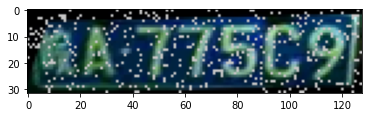

In [13]:
plt.imshow(gpu_transform(train_dataset[1223][0]).permute(1,2,0))

In [14]:
device = "cuda"
model = Model(len(alphabet) + 1).to(device)
loss = nn.CTCLoss()
optimizer = MADGRAD(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=1,
    threshold=0.0005,
    threshold_mode="abs",
)


In [15]:
ocr = OCR(
    model,
    optimizer,
    loss,
    WORD_LENGTH,
    alphabet,
    gpu_transform,
    scheduler=scheduler,
    device=device
)


In [16]:
n_epochs = 15
metrics = [Accuracy(), torchmetrics.CharErrorRate()]
train_losses, val_losses = ocr.fit(train, val, n_epochs, metrics, scheduler_metric='Accuracy')

Epoch 001


Phase train: 100%|██████████| 449/449 [08:50<00:00,  1.18s/it]


	Loss: 1.85636
	Accuracy: 0.16110
	CharErrorRate: 0.52306



Phase val: 100%|██████████| 49/49 [00:26<00:00,  1.87it/s]


	Loss: 0.07960
	Accuracy: 0.88764
	CharErrorRate: 0.01428


LR: 0.001
----------------------------------------
Epoch 002


Phase train: 100%|██████████| 449/449 [09:28<00:00,  1.27s/it]


	Loss: 0.08450
	Accuracy: 0.88806
	CharErrorRate: 0.01975



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.91it/s]


	Loss: 0.01329
	Accuracy: 0.95865
	CharErrorRate: 0.00319


LR: 0.001
----------------------------------------
Epoch 003


Phase train: 100%|██████████| 449/449 [09:25<00:00,  1.26s/it]


	Loss: 0.02405
	Accuracy: 0.95763
	CharErrorRate: 0.00629



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


	Loss: 0.00746
	Accuracy: 0.96880
	CharErrorRate: 0.00169


LR: 0.001
----------------------------------------
Epoch 004


Phase train: 100%|██████████| 449/449 [09:37<00:00,  1.29s/it]


	Loss: 0.01495
	Accuracy: 0.97314
	CharErrorRate: 0.00383



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.90it/s]


	Loss: 0.00551
	Accuracy: 0.97120
	CharErrorRate: 0.00133


LR: 0.001
----------------------------------------
Epoch 005


Phase train: 100%|██████████| 449/449 [08:49<00:00,  1.18s/it]


	Loss: 0.01491
	Accuracy: 0.97338
	CharErrorRate: 0.00389



Phase val: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s]


	Loss: 0.00545
	Accuracy: 0.97195
	CharErrorRate: 0.00129


LR: 0.001
----------------------------------------
Epoch 006


Phase train: 100%|██████████| 449/449 [08:59<00:00,  1.20s/it]


	Loss: 0.00962
	Accuracy: 0.98185
	CharErrorRate: 0.00249



Phase val: 100%|██████████| 49/49 [00:24<00:00,  1.97it/s]


	Loss: 0.00294
	Accuracy: 0.97600
	CharErrorRate: 0.00064


LR: 0.001
----------------------------------------
Epoch 007


Phase train: 100%|██████████| 449/449 [09:19<00:00,  1.25s/it]


	Loss: 0.00871
	Accuracy: 0.98283
	CharErrorRate: 0.00229



Phase val: 100%|██████████| 49/49 [00:26<00:00,  1.82it/s]


	Loss: 0.00335
	Accuracy: 0.97500
	CharErrorRate: 0.00079


LR: 0.001
----------------------------------------
Epoch 008


Phase train: 100%|██████████| 449/449 [09:21<00:00,  1.25s/it]


	Loss: 0.00707
	Accuracy: 0.98574
	CharErrorRate: 0.00188



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


	Loss: 0.00246
	Accuracy: 0.97650
	CharErrorRate: 0.00056


LR: 0.001
----------------------------------------
Epoch 009


Phase train: 100%|██████████| 449/449 [09:24<00:00,  1.26s/it]


	Loss: 0.00581
	Accuracy: 0.98760
	CharErrorRate: 0.00158



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.92it/s]


	Loss: 0.00187
	Accuracy: 0.97755
	CharErrorRate: 0.00042


LR: 0.001
----------------------------------------
Epoch 010


Phase train: 100%|██████████| 449/449 [09:21<00:00,  1.25s/it]


	Loss: 0.00516
	Accuracy: 0.98659
	CharErrorRate: 0.00170



Phase val: 100%|██████████| 49/49 [00:26<00:00,  1.85it/s]


	Loss: 0.00158
	Accuracy: 0.97810
	CharErrorRate: 0.00033


LR: 0.001
----------------------------------------
Epoch 011


Phase train: 100%|██████████| 449/449 [09:24<00:00,  1.26s/it]


	Loss: 0.00469
	Accuracy: 0.98964
	CharErrorRate: 0.00127



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.92it/s]


	Loss: 0.00148
	Accuracy: 0.97815
	CharErrorRate: 0.00031


LR: 0.001
----------------------------------------
Epoch 012


Phase train: 100%|██████████| 449/449 [09:15<00:00,  1.24s/it]


	Loss: 0.00493
	Accuracy: 0.98926
	CharErrorRate: 0.00132



Phase val: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s]


	Loss: 0.00145
	Accuracy: 0.97790
	CharErrorRate: 0.00034


LR: 0.001
----------------------------------------
Epoch 013


Phase train: 100%|██████████| 449/449 [08:55<00:00,  1.19s/it]


	Loss: 0.00356
	Accuracy: 0.99198
	CharErrorRate: 0.00091



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.92it/s]


	Loss: 0.00096
	Accuracy: 0.97890
	CharErrorRate: 0.00020


LR: 0.0001
----------------------------------------
Epoch 014


Phase train: 100%|██████████| 449/449 [09:02<00:00,  1.21s/it]


	Loss: 0.00415
	Accuracy: 0.99138
	CharErrorRate: 0.00106



Phase val: 100%|██████████| 49/49 [00:24<00:00,  2.02it/s]


	Loss: 0.00099
	Accuracy: 0.97900
	CharErrorRate: 0.00019


LR: 0.0001
----------------------------------------
Epoch 015


Phase train: 100%|██████████| 449/449 [08:49<00:00,  1.18s/it]


	Loss: 0.00269
	Accuracy: 0.99328
	CharErrorRate: 0.00071



Phase val: 100%|██████████| 49/49 [00:25<00:00,  1.90it/s]

	Loss: 0.00091
	Accuracy: 0.97910
	CharErrorRate: 0.00017


LR: 0.0001
----------------------------------------


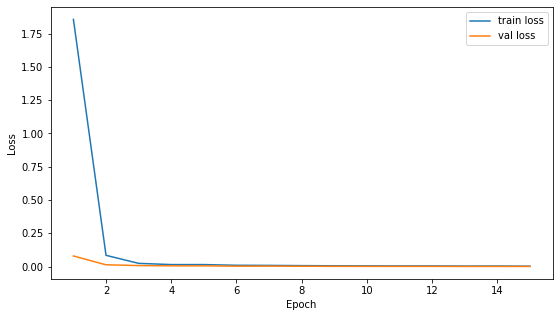

In [25]:
plt.figure(figsize=(9, 5))
sns.lineplot(x=np.arange(1, n_epochs+1), y=train_losses, label='train loss')
ax = sns.lineplot(x=np.arange(1, n_epochs+1), y=val_losses, label='val loss')
ax.set(xlabel='Epoch', ylabel='Loss');

In [17]:
torch.save(ocr.state_dict(), './models/fcnn_lstm_ctcloss_madgrad.pt')

## Метрики на тестовой выборке

In [19]:
ocr.score_test(test, metrics)

Phase test: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]

	Loss: 0.00583
	Accuracy: 0.99330
	CharErrorRate: 0.00120



(0.005832448784559623,
 {'Accuracy': 0.9932993299329933, 'CharErrorRate': tensor(0.0012)})

# Error Handling

In [18]:
outp = ocr.get_test_scores(test_dataset, torchmetrics.CharErrorRate(), device='cuda')

100%|██████████| 9999/9999 [01:09<00:00, 144.36it/s]


In [58]:
scores = np.array(outp)
scores_sorted_idx = scores.argsort()[::-1]
sorted_scores = scores[scores_sorted_idx]

In [59]:
sorted_scores[:70]

array([0.5714286 , 0.42857143, 0.42857143, 0.42857143, 0.42857143,
       0.2857143 , 0.2857143 , 0.2857143 , 0.2857143 , 0.2857143 ,
       0.2857143 , 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715, 0.        , 0.        , 0.        ])

In [73]:
@torch.no_grad()
def plot(start=0):
    plt.figure(figsize=(20, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        img, label = test_dataset[scores_sorted_idx[i+start]]
        _, predicted = ocr.predict(img.cuda())
        ax.set_title(f'{label}-{predicted[0]}; {sorted_scores[i+start]:.3f}')
        plt.imshow(img.permute(1,2,0))

### Топ 25 CER

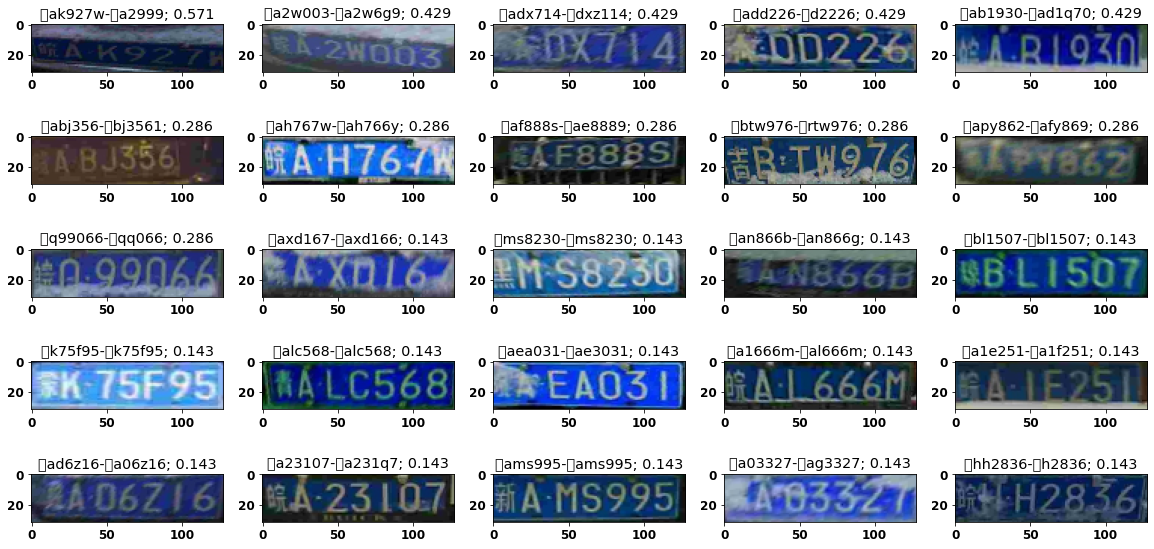

In [71]:
plot()

### Топ 25-50 CER

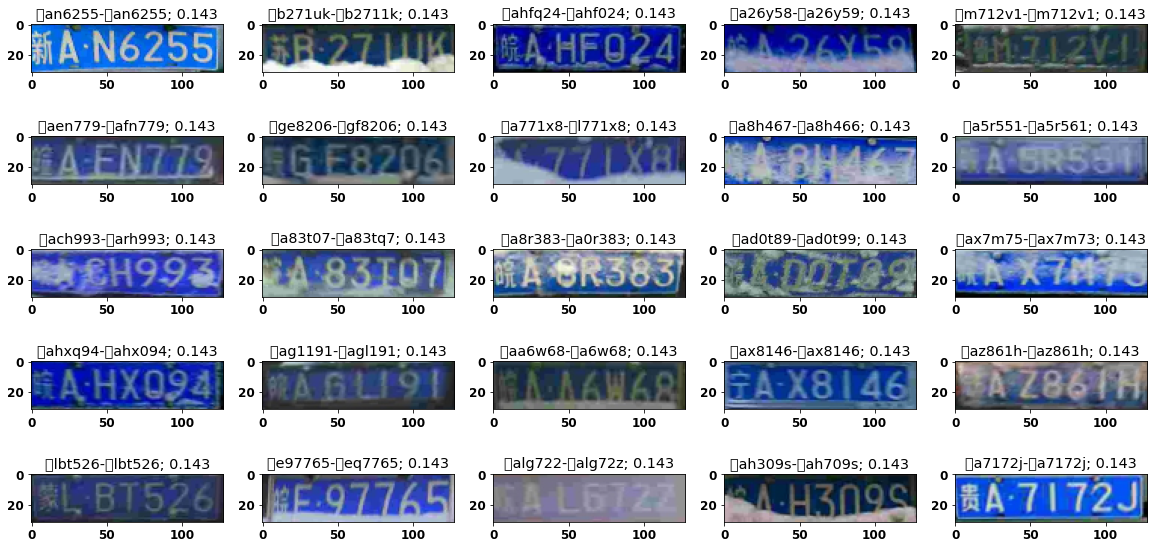

In [75]:
plot(25)

# Отчет

### Реализовано
 - Свой класс данных
 - Механизм аугментации изображений
 - Предложенная в задании архитектура (FCNN + Bidirectional LSTM) 
 - Свой цикл обучения модели
 - Энкодер/декодер символов, необходимый для данной архитектуры
 
### Анализ ошибок модели
Было замечено, что модель чаще всего ошибается на картинках с некторыми помехами (снег или потертости).  
Для решения проблемы были использованы аугментации из библиотеки albumentations: 
- PixelDropout - менят цвет случайных пикселей  
- CoarseDropout - добавляет прямоугольники в случайных местах 

Также использовался ColorJitter для лучшего предсказания на темных фото и на фото, с искаженным цветом. 

Данные аугментации улучшили метрики, но не решили проблему полностью, модель все еще может ошибаться в некоторых случаях.  
Чаще всего она неверно предсказывает лишь 1 символ. Нередко это происходит в тех случаях, когда из-за шума можно спутать символы. Например, O-Q и F-E.  
Наихудшуий CER модель имеет на 2 изображениях с искаженной перспективой и на изображениях с большим шумом. RandomPerspective конкретно для этих 2 случаев не помог. 

Возможные пути устранения:
 - На последних эпохах заменять часть батча на "плохие" изображения
 - Реализовать аугментации, имитирующие типичные помехи на изображениях.   
Например, внизу часто заметен снег (или что-то еще), поэтому можно закрашивать нижние пиксели в форме синусоиды.  
 - Найти больше данных

 Однако все равно будут случаи, когда одназначно нельзя определить символы
 
  
### Метрики на тестовой выборке
    Loss: 0.00583
	Accuracy: 0.99330
	CharErrorRate: 0.00120



 